# Quantum LSTM for classification

In this example we will train a Quantum Long Short-Term Memory model to predict whether a sentence is related to food or IT.

Let us start by importing some libraries.

In [2]:
import sys; sys.path.append('../src')
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt
cmap = matplotlib.colormaps.get_cmap('tab20c')
colors = cmap.colors

The Long Short-Term Memory (LSTM) model is a Recurrent Neural Network (RNN) designed to deal with the vanishing gradient problem exhibit by traditional RNNs when learning long-term dependencies of sequential data (the likes of sentences).

Each memory block in the LSTM network consist of a cell state *c*, a series of layers or gates determining the information forgotten and updated, and the information passed to the next memory block as a hidden state *h*.

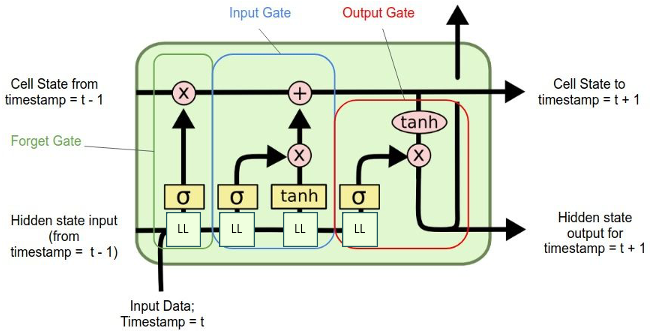

In [3]:
Image(filename='../Figures/lstmmodel.png', width=700)

The Quantum LSTM (QLSTM) model replaces the classical gates on the LSTM model with parametrized quantum circuits (PQCs).

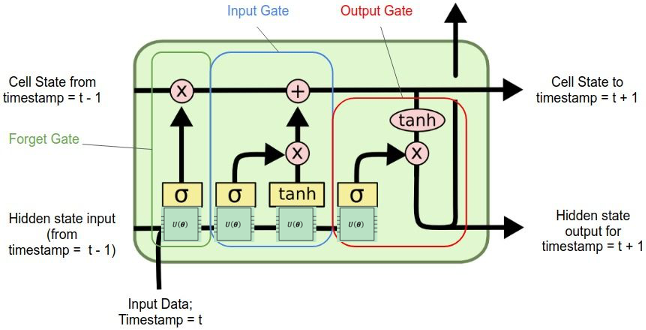

In [4]:
Image(filename='../Figures/qlstmmodel.png', width=700)

### Reading the dataset

The dataset used in this exercise is consists of sentences related either to *food* or *IT*. The goal of the trained QLSTM model is to predict the labels of 20 of these sentences in the test dataset.

In [5]:
from qlstm_aux import read_data

train_data = read_data('../Datasets/mc_train_data.txt')
val_data = read_data('../Datasets/mc_test_data.txt')
test_data = read_data('../Datasets/mc_test_data.txt')

A couple of sentences conforming the training dataset and their labels are:

$${\rm skillful\ man\ prepares\ sauce\ .\qquad food}\rightarrow 1$$
$${\rm skillful\ woman\ debugs\ program\ .\qquad IT}\rightarrow 0$$

The *read_data* function returns the strings **1** and **0** for the labels **food** and **IT**, respectively.



### Classical data processing

To train the QLSTM model we first select balanced subsets of training and test datasets, and construct a dictionary from them.

In [6]:
from qlstm_aux import subset_idxs_dist, words_to_idxs

train_classes = [0,1]
train_size = 60
test_size = 20
balanced = True
randomized = False

train_idxs, train_dist = subset_idxs_dist(train_data, train_classes, train_size, balanced, randomized)
test_idxs, test_dist = subset_idxs_dist(test_data, train_classes, test_size, balanced, randomized)
words_to_idxs = words_to_idxs(train_data+val_data, train_idxs)

The dictionary of the balanced training set is shown below.

In [7]:
for (word, label) in words_to_idxs.items():
    print('{}: {}'.format(label, word))

0: skillful
1: man
2: prepares
3: sauce
4: bakes
5: dinner
6: woman
7: cooks
8: tasty
9: meal
10: debugs
11: program
12: person
13: runs
14: useful
15: application
16: software


The QLSTM model uses a classical linear layer to map the words in a sentence into feature vectors. At step *t*, the feature vector for the *t*-th word in the sentence and the hidden state at step *t-1* are concatenated into a data vector *v*. This vector is then passed through a linear layer and encoded into the PQCs.

The embedding and hidden dimensions of the feature and hidden vectors are hyperparameters of the QLSTM model.

### Constructing the PQCs

Each PQC in the QLSTM model is constructed as a brick-layer ansatz with an Ising ZZ unitary. This anstaz is show in the figure below. The data is encoded into the orange gates, while the blue ones have a trainable parameters.

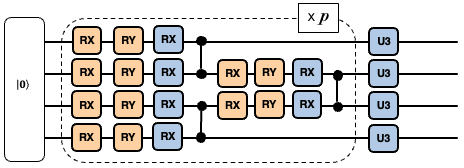

In [8]:
Image(filename='../Figures/issingzzansatz.png', width=700)

### Defining the model

The *QLSTMClassifier* model can be found in *qlstm_models.py*. It builds on top of the *QLSTM* model at https://github.com/rdisipio/qlstm. It is trained using *PyTorch*, the negative log likelihood loss function and the Adam gradient descent optimizer.

In [9]:
embedding_dim = 8
hidden_dim = 6
num_words = len(words_to_idxs)
num_labels = len(train_classes)
num_qubits = 2
num_qlayers = 1
backend = 'default.qubit'

In [10]:
from qlstm_models import QLSTMClassifier

model = QLSTMClassifier(embedding_dim,
                        hidden_dim,
                        vocab_size=num_words,
                        tagset_size=num_labels,
                        n_qubits=num_qubits,
                        n_qlayers=num_qlayers,
                        ising=True,
                        probs=False,
                        backend=backend)

weights = torch.tensor(list(pow(train_size/len(train_classes)/train_dist[key],3) for key in train_dist.keys()), dtype=torch.float)
learning_rate = 0.001

loss_function = nn.NLLLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Model training

The training can be speedup using distributed parallel training and data parallelism:

- The training set is split among different MPI processes.
- Every MPI process trains a submodel using their training subsets.
- The loss function's gradient is communicated to every MPI process before updating the model's parameters.

$$\nabla f = \sum_i \nabla_{\rm rank} f$$

In [11]:
num_epochs = 20
training = {'loss': [], 'acc': []}
test = {'loss': [], 'acc': []}

In [12]:
from numpy import mean, around
from numpy.random import shuffle
from qlstm_aux import prepare_sequence
'''
# To parallelize the model training, we split the training dataset among multiple MPI processes.
# The gradient of the loss functrion are communicated before updating the parameters.

from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

jobs_per_rank = len(train_data) // size
leftover = len(train_data) % size
if rank > size-leftover-1: jobs_per_rank += 1
jobsizes = comm.allgather(jobs_per_rank)
starts = list(sum(jobsizes[:i]) for i in range(len(jobsizes)))
rank_idxs = list(train_idxs[i] for i in range(starts[rank], starts[rank] + jobsizes[rank]))

# Parallel version would require to replace train_idxs below for rank_idxs
'''
for epoch in range(num_epochs):

    shuffle(train_idxs)

    rank_losses = []
    rank_preds = []
    rank_targets = []
    accuracy = torch.tensor([0], dtype=torch.float32)
    
    if epoch == num_epochs-1: rank_confusion = {c: [] for c in train_classes}

    for k, i in enumerate(train_idxs):
        
        model.zero_grad(set_to_none=False)
        
        if i != -1:
            sentence = train_data[i][2:-1].split()
            sentence_in = prepare_sequence(sentence, words_to_idxs)
            label = list(0 for j in range(len(train_classes)))
            for j, key in enumerate(train_dist.keys()):
                if int(train_data[i][:2]) == key: label[j] += 1
            label = torch.tensor(label, dtype=torch.long)
            rank_targets.append(label)

            scores = model(sentence_in)
            loss = loss_function(scores, torch.tensor([label.argmax(dim=-1)]))
            loss.backward()
            rank_losses.append(float(loss))
            pred = list(0 for j in range(len(train_classes)))
            pred[scores.argmax().item()] += 1
            pred = torch.tensor(pred, dtype=torch.long)
            rank_preds.append(pred)

            if epoch == num_epochs-1: rank_confusion[int(train_data[i][:2])].append(scores.argmax().item())

        else: loss = torch.tensor([-100.], dtype=torch.float32)
        '''
        for param in model.parameters():
            temp = torch.tensor(zeros(param.shape), dtype=torch.float32)
            comm.Allreduce(param.grad, temp, op=MPI.SUM)
            param.grad = temp

        if num_qubits > 0:
            for param in model.lstm.VQC['forget'].parameters():
                temp = torch.tensor(zeros(param.shape), dtype=torch.float32)
                comm.Allreduce(param.grad, temp, op=MPI.SUM)
                param.grad = temp
            for param in model.lstm.VQC['input'].parameters():
                temp = torch.tensor(zeros(param.shape), dtype=torch.float32)
                comm.Allreduce(param.grad, temp, op=MPI.SUM)
                param.grad = temp
            for param in model.lstm.VQC['update'].parameters():
                temp = torch.tensor(zeros(param.shape), dtype=torch.float32)
                comm.Allreduce(param.grad, temp, op=MPI.SUM)
                param.grad = temp
            for param in model.lstm.VQC['output'].parameters():
                temp = torch.tensor(zeros(param.shape), dtype=torch.float32)
                comm.Allreduce(param.grad, temp, op=MPI.SUM)
                param.grad = temp
        '''
        optimizer.step()
    '''
    losses = []
    preds = []
    targets = []

    temp = comm.allgather(rank_losses)
    for sublist in temp: losses += list(item for item in sublist)
    temp = comm.allgather(rank_preds)
    for sublist in temp: preds += list(item for item in sublist)
    temp = comm.allgather(rank_targets)
    for sublist in temp: targets += list(item for item in sublist)
    if epoch == num_epochs-1:
        temp = comm.allgather(rank_confusion)
        confusion = {c: [] for c in classes}
        for sublist in temp:
            for c in classes: confusion[c] += sublist[c]
    '''
    avg_loss = mean(rank_losses)
    training['loss'].append(avg_loss)

    preds = torch.cat(rank_preds)
    targets = torch.cat(rank_targets)
    corrects = (preds == targets)
    accuracy = corrects.sum().float() / float(targets.size(0))
    training['acc'].append(accuracy)

    if epoch%10==0: print('Loss: {}\tAccuracy: {}'.format(around(avg_loss,4), around(accuracy,4)))

Loss: -0.499	Accuracy: 0.5
Loss: -0.7253	Accuracy: 0.916700005531311


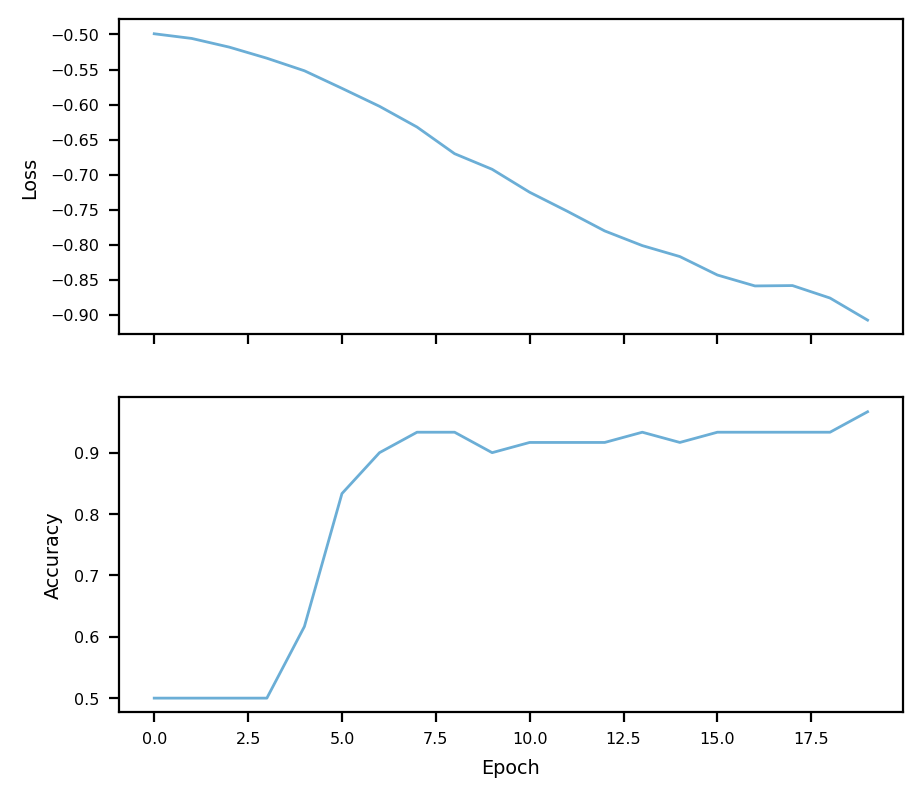

In [13]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(3.375*3/2, 3.375*4/3), dpi=200)
for ax in axs.ravel():
    ax.tick_params(labelsize='xx-small')
axs[0].set_ylabel('Loss', fontsize='x-small')
axs[1].set_ylabel('Accuracy', fontsize='x-small')
axs[1].set_xlabel('Epoch', fontsize='x-small')
axs[0].plot(training['loss'], lw=1, color=colors[1], label='LSTM');
axs[1].plot(training['acc'], lw=1, color=colors[1], label='LSTM');

In [14]:
rank_losses = []
rank_preds = []
rank_targets = []
accuracy = torch.tensor([0], dtype=torch.float32)
    
rank_confusion = {c: [] for c in train_classes}

for k, i in enumerate(test_idxs):
        
    if i != -1:
        sentence = test_data[i][2:-1].split()
        sentence_in = prepare_sequence(sentence, words_to_idxs)
        label = list(0 for j in range(len(train_classes)))
        for j, key in enumerate(test_dist.keys()):
            if int(test_data[i][:2]) == key: label[j] += 1
        label = torch.tensor(label, dtype=torch.long)
        rank_targets.append(label)

        scores = model(sentence_in)
        loss = loss_function(scores, torch.tensor([label.argmax(dim=-1)]))
        rank_losses.append(float(loss))
        pred = list(0 for j in range(len(train_classes)))
        pred[scores.argmax().item()] += 1
        pred = torch.tensor(pred, dtype=torch.long)
        rank_preds.append(pred)

        rank_confusion[int(test_data[i][:2])].append(scores.argmax().item())

    else: loss = torch.tensor([-100.], dtype=torch.float32)
        
avg_loss = mean(rank_losses)
test['loss'].append(avg_loss)

preds = torch.cat(rank_preds)
targets = torch.cat(rank_targets)
corrects = (preds == targets)
accuracy = corrects.sum().float() / float(targets.size(0))
test['acc'].append(accuracy)

print('Loss: {}\tAccuracy: {}'.format(around(avg_loss,4), around(accuracy,4)))

Loss: -0.871	Accuracy: 0.949999988079071


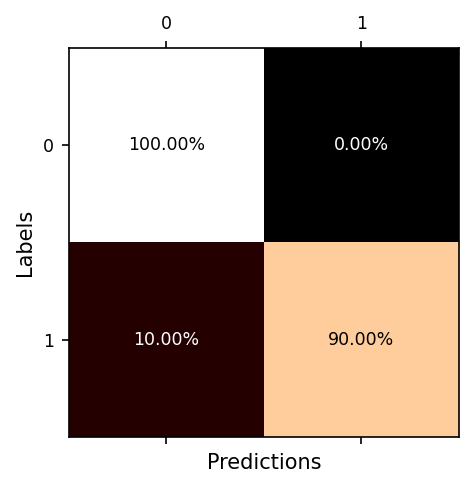

In [15]:
from numpy import array, arange
from tut_aux import annotate_heatmap

confusion = []
for i, c in enumerate(rank_confusion.keys()):
    temp = list(0 for c in train_classes)
    for pc in rank_confusion[c]: temp[pc] += 1/test_dist[c]
    confusion.append(temp)
confusion = array(confusion)

labels = list(c for c in test_dist.keys())

fig, ax = plt.subplots(figsize=(3.375, 3.375), dpi=150)
ax.set_ylabel('Labels', fontsize='medium')
ax.set_xlabel('Predictions', fontsize='medium')
ax.tick_params(labelsize='small')
ax.set_yticks(arange(len(labels)), labels)
ax.set_xticks(arange(len(labels)), labels)
im = ax.matshow(100*confusion, vmin=0, vmax=100, cmap='gist_heat')
texts = annotate_heatmap(im, valfmt='{x:.2f}%', fontsize='small')